In [ ]:
import re  # Import the 're' module for regular expressions
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define custom Gujarati stopwords
gujarati_stopwords = set(['और', 'का', 'है', 'के', 'की', 'से', 'को', 'पर', 'यह', 'था', 'हूँ', 'ही', 'हैं', 'इस', 'था', 'हो', 'है', 'भी', 'जो', 'तक', 'में', 'नहीं', 'तो', 'कर', 'रहा', 'थे', 'एक', 'कि', 'था', 'थे', 'सब', 'कभी', 'होता', 'बाद', 'साथ', 'लिए', 'दो', 'अब', 'तक', 'आप', 'हम', 'वे', 'उन', 'उनका', 'मुझे', 'यहाँ', 'किया', 'दिया', 'गया', 'रही', 'रहे', 'क्या', 'कौन', 'कब', 'कैसे', 'जैसे', 'जब', 'किस', 'यदि', 'यही', 'उसे', 'वह', 'थी', 'रख', 'हो', 'हूँ', 'जाता', 'जाती', 'रहेगा', 'होगा', 'जाने', 'करना', 'आदि', 'कहाँ', 'यानी', 'उसका'
])

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Hindi (Devanagari) characters
    text = ' '.join([word for word in text.split() if word not in gujarati_stopwords])  # Remove stopwords
    return text

# Load the dataset
data = pd.read_csv('hindi_fnl_dataset.csv')  # Replace with actual file path

# Apply preprocessing to the 'Sentence' column
data['cleaned_sentence'] = data['Sentence'].apply(preprocess_text)

# Encode the target labels for Sentiment and Emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
data['encoded_sentiment'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['encoded_emotion'] = emotion_encoder.fit_transform(data['Emotion'])



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_sentiment_train, y_sentiment_test, y_emotion_train, y_emotion_test = train_test_split(
    data['cleaned_sentence'], data['encoded_sentiment'], data['encoded_emotion'], test_size=0.2, random_state=42)

# Tokenize the text data and pad sequences for uniform length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make them the same length
max_seq_len = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        query, value = inputs
        score = tf.matmul(query, value, transpose_b=True)
        distribution = tf.nn.softmax(score, axis=-1)
        attention_output = tf.matmul(distribution, value)
        return attention_output

# Define the LSTM model with Attention
embedding_dim = 128
lstm_units = 64

# Input layer
input_layer = Input(shape=(max_seq_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(input_layer)

# LSTM layer
lstm_layer = LSTM(lstm_units, return_sequences=True)(embedding_layer)

# Attention layer
attention_output = AttentionLayer()([lstm_layer, lstm_layer])

# Flatten attention output
flatten_attention = attention_output[:, -1, :]  # Use the final step of attention output

# Shared Dense layer
shared_dense_layer = Dense(64, activation='relu')(flatten_attention)

# Sentiment output
sentiment_output = Dense(len(sentiment_encoder.classes_), activation='softmax', name='sentiment_output')(shared_dense_layer)

# Emotion output
emotion_output = Dense(len(emotion_encoder.classes_), activation='softmax', name='emotion_output')(shared_dense_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[sentiment_output, emotion_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'})

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 12)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 12, 128)        │        953,856 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 12, 64)         │         49,408 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 12, 64)         │              0 │ lstm[0][0], lstm[0][0] │
│ (AttentionLayer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 64)             │              0 │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          4,160 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 9)              │            585 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,008,204 (3.85 MB)

 Trainable params: 1,008,204 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train_pad,
    {'sentiment_output': y_sentiment_train, 'emotion_output': y_emotion_train},
    epochs=1,  # Adjust number of epochs if needed
    batch_size=64,
    validation_data=(X_test_pad, {'sentiment_output': y_sentiment_test, 'emotion_output': y_emotion_test})
)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - emotion_output_accuracy: 0.7525 - loss: 0.8572 - sentiment_output_accuracy: 0.8978 - val_emotion_output_accuracy: 0.9639 - val_loss: 0.1003 - val_sentiment_output_accuracy: 0.9952


In [ ]:
pip install numpy


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Evaluate the model on the test set
results = model.evaluate(X_test_pad, [y_sentiment_test, y_emotion_test])
print(f"Evaluation Results: {results}")

# Predict sentiment and emotion on test data
y_sentiment_pred, y_emotion_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_sentiment_pred = np.argmax(y_sentiment_pred, axis=1)
y_emotion_pred = np.argmax(y_emotion_pred, axis=1)

# Sentiment evaluation metrics
sentiment_accuracy = accuracy_score(y_sentiment_test, y_sentiment_pred)
sentiment_precision = precision_score(y_sentiment_test, y_sentiment_pred, average='weighted')
sentiment_recall = recall_score(y_sentiment_test, y_sentiment_pred, average='weighted')
sentiment_f1 = f1_score(y_sentiment_test, y_sentiment_pred, average='weighted')

# Emotion evaluation metrics
emotion_accuracy = accuracy_score(y_emotion_test, y_emotion_pred)
emotion_precision = precision_score(y_emotion_test, y_emotion_pred, average='weighted')
emotion_recall = recall_score(y_emotion_test, y_emotion_pred, average='weighted')
emotion_f1 = f1_score(y_emotion_test, y_emotion_pred, average='weighted')

# Display sentiment results
print(f"Sentiment - Accuracy: {sentiment_accuracy}, Precision: {sentiment_precision}, Recall: {sentiment_recall}, F1 Score: {sentiment_f1}")

# Display emotion results
print(f"Emotion - Accuracy: {emotion_accuracy}, Precision: {emotion_precision}, Recall: {emotion_recall}, F1 Score: {emotion_f1}")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - emotion_output_accuracy: 0.9647 - loss: 0.0990 - sentiment_output_accuracy: 0.9952
Evaluation Results: [0.10030833631753922, 0.9638500213623047, 0.9951500296592712]
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Sentiment - Accuracy: 0.99515, Precision: 0.9951527701433651, Recall: 0.99515, F1 Score: 0.9951509503085747
Emotion - Accuracy: 0.96385, Precision: 0.9643870291416224, Recall: 0.96385, F1 Score: 0.963738784602771


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


In [ ]:
# Binarize the sentiment and emotion labels for AUC calculation
y_sentiment_test_binarized = label_binarize(y_sentiment_test, classes=range(len(sentiment_encoder.classes_)))
y_emotion_test_binarized = label_binarize(y_emotion_test, classes=range(len(emotion_encoder.classes_)))

# Get the predicted probabilities for each class
y_sentiment_pred_prob, y_emotion_pred_prob = model.predict(X_test_pad)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


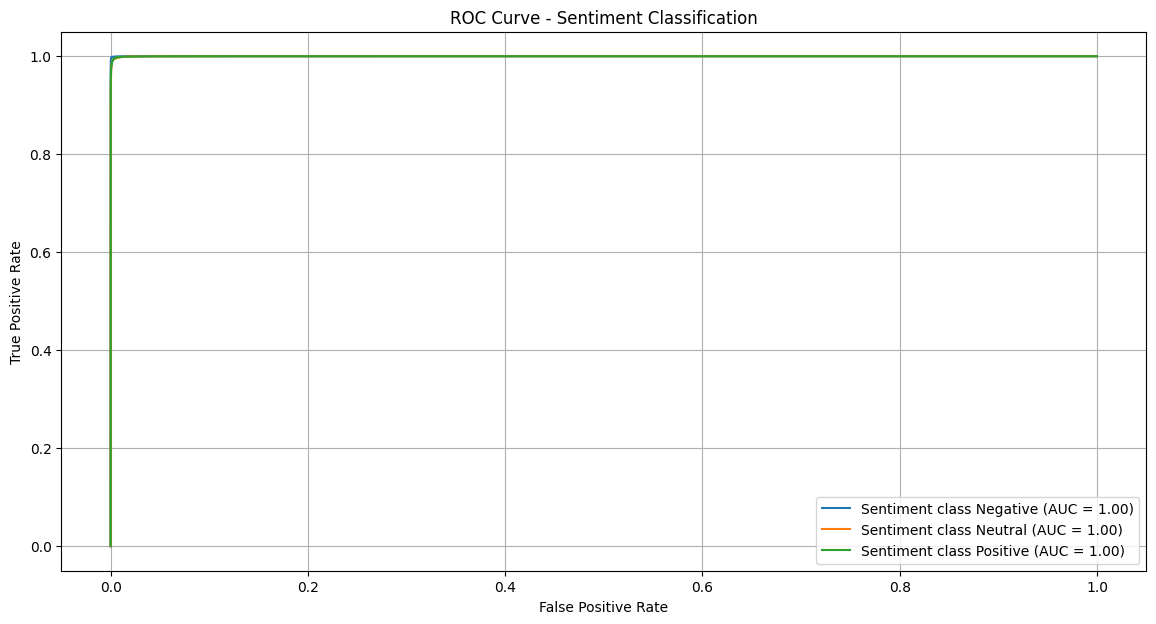

In [ ]:
# Plotting ROC curve for each sentiment class
plt.figure(figsize=(14, 7))

# Sentiment ROC curves
for i in range(len(sentiment_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_sentiment_test_binarized[:, i], y_sentiment_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Sentiment class {sentiment_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Sentiment Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


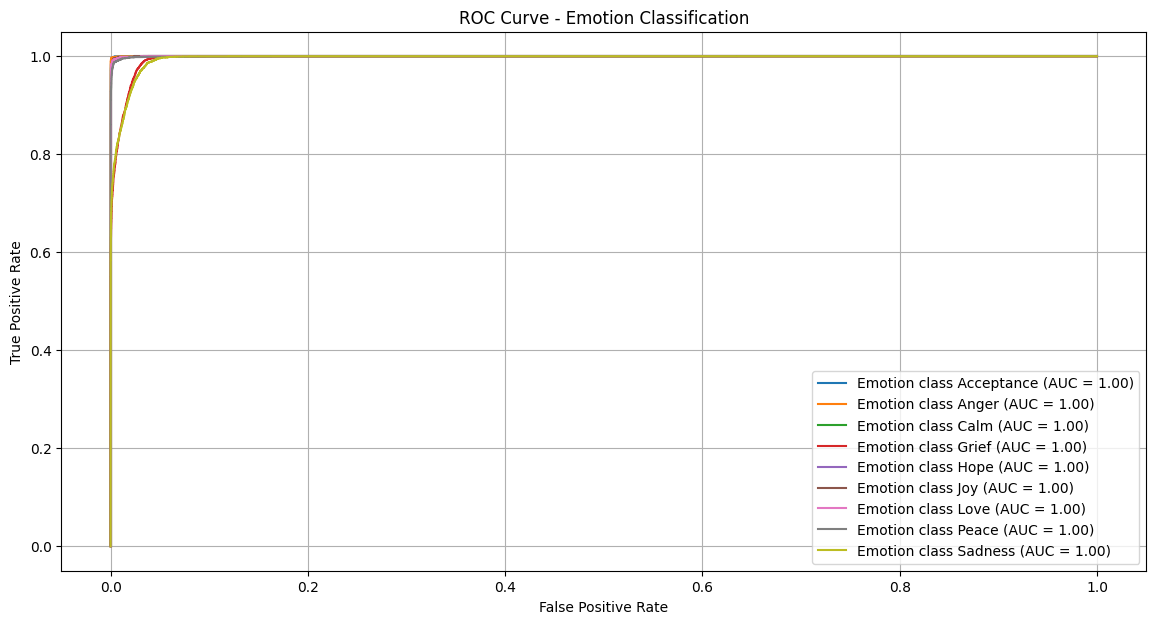

In [ ]:
# Plotting ROC curve for each emotion class
plt.figure(figsize=(14, 7))

# Emotion ROC curves
for i in range(len(emotion_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_emotion_test_binarized[:, i], y_emotion_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Emotion class {emotion_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Emotion Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Define 5 custom Gujarati sentences for testing
custom_sentences =["तेरी बातें दिल को सुकून देती हैं, जैसे सावन की पहली बारिश",
"दिल के कोने में कुछ टूटता हुआ सा महसूस होता है, जैसे पत्ते गिरते हैं शाखों से",
"अगर आप अपने सपनों को सच करना चाहते हैं, तो आपको लगातार प्रयास करना होगा",
"समय के साथ हर मुश्किल हल हो जाती है, बस धैर्य और विश्वास बनाए रखें",
"जब हम अपनी गलतियों से सीखते हैं, तभी हम जीवन में बेहतर बन पाते हैं"
]

# English translations of the custom sentences
english_translations = ["Your words bring peace to my heart, like the first rain of the monsoon",
"In the depths of my heart, there is a silence, like an instrument without melody",
"If you want to make your dreams come true, you have to keep making continuous efforts",
"With time, every difficulty is resolved, just keep patience and faith",
"Only when we learn from our mistakes can we become better in life"
]

# Preprocess and tokenize the custom sentences
custom_sequences = tokenizer.texts_to_sequences(custom_sentences)
custom_padded_sequences = pad_sequences(custom_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion using the trained model
custom_sentiment_pred, custom_emotion_pred = model.predict(custom_padded_sequences)

# Convert predictions to class labels
custom_sentiment_pred_labels = np.argmax(custom_sentiment_pred, axis=1)
custom_emotion_pred_labels = np.argmax(custom_emotion_pred, axis=1)

# Get the label names from encoders
predicted_sentiment_labels = sentiment_encoder.inverse_transform(custom_sentiment_pred_labels)
predicted_emotion_labels = emotion_encoder.inverse_transform(custom_emotion_pred_labels)

# Display the results for each sentence
for i, sentence in enumerate(custom_sentences):
    print(f"Sentence (Gujarati): {sentence}")
    print(f"English Translation: {english_translations[i]}")
    print(f"Predicted Sentiment: {predicted_sentiment_labels[i]}")
    print(f"Predicted Emotion: {predicted_emotion_labels[i]}")
    print("----------------------------------------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sentence (Gujarati): तेरी बातें दिल को सुकून देती हैं, जैसे सावन की पहली बारिश
English Translation: Your words bring peace to my heart, like the first rain of the monsoon
Predicted Sentiment: Positive
Predicted Emotion: Love
----------------------------------------------------
Sentence (Gujarati): दिल के कोने में कुछ टूटता हुआ सा महसूस होता है, जैसे पत्ते गिरते हैं शाखों से
English Translation: In the depths of my heart, there is a silence, like an instrument without melody
Predicted Sentiment: Positive
Predicted Emotion: Love
----------------------------------------------------
Sentence (Gujarati): अगर आप अपने सपनों को सच करना चाहते हैं, तो आपको लगातार प्रयास करना होगा
English Translation: If you want to make your dreams come true, you have to keep making continuous efforts
Predicted Sentiment: Positive
Predicted Emotion: Hope
----------------------------------------------------
Sentence (Gujarati): समय के साथ हर मुश्किल हल हो जाती है, बस धैर्य और

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample

# Load the dataset
data = pd.read_csv('hindi_fnl_dataset.csv')  # Adjust to your dataset path

# Define Gujarati stopwords
gujarati_stopwords = set(['और', 'का', 'है', 'के', 'की', 'से', 'को', 'पर', 'यह', 'था', 'हूँ', 'ही', 'हैं', 'इस', 'था', 'हो', 'है', 'भी', 'जो', 'तक', 'में', 'नहीं', 'तो', 'कर', 'रहा', 'थे', 'एक', 'कि', 'था', 'थे', 'सब', 'कभी', 'होता', 'बाद', 'साथ', 'लिए', 'दो', 'अब', 'तक', 'आप', 'हम', 'वे', 'उन', 'उनका', 'मुझे', 'यहाँ', 'किया', 'दिया', 'गया', 'रही', 'रहे', 'क्या', 'कौन', 'कब', 'कैसे', 'जैसे', 'जब', 'किस', 'यदि', 'यही', 'उसे', 'वह', 'थी', 'रख', 'हो', 'हूँ', 'जाता', 'जाती', 'रहेगा', 'होगा', 'जाने', 'करना', 'आदि', 'कहाँ', 'यानी', 'उसका'
])
# Preprocess text
def preprocess_text(text):
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Hindi (Devanagari) characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

data['cleaned_sentence'] = data['Sentence'].apply(preprocess_text)

# Encode the target labels for Sentiment and Emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
data['encoded_sentiment'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['encoded_emotion'] = emotion_encoder.fit_transform(data['Emotion'])

# Handle class imbalance (oversampling minority classes)
sentiment_counts = data['encoded_sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resample the minority class to match the majority
minority_class = data[data['encoded_sentiment'] == min_class]
majority_class = data[data['encoded_sentiment'] != min_class]
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
data_balanced = pd.concat([majority_class, minority_upsampled])

# Split data into training and test sets
X_train, X_test, y_sentiment_train, y_sentiment_test, y_emotion_train, y_emotion_test = train_test_split(
    data_balanced['cleaned_sentence'], data_balanced['encoded_sentiment'], data_balanced['encoded_emotion'], test_size=0.2, random_state=42)

# Tokenize the text data and pad sequences for uniform length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make them the same length
max_seq_len = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        query, value = inputs
        score = tf.matmul(query, value, transpose_b=True)
        distribution = tf.nn.softmax(score, axis=-1)
        attention_output = tf.matmul(distribution, value)
        return attention_output

# Build the LSTM model with Attention and Bidirectional LSTM
embedding_dim = 128
lstm_units = 64

# Input layer
input_layer = Input(shape=(max_seq_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

# Attention layer
attention_output = AttentionLayer()([lstm_layer, lstm_layer])

# Flatten attention output
flatten_attention = attention_output[:, -1, :]  # Use the final step of attention output

# Shared Dense layer
shared_dense_layer = Dense(64, activation='relu')(flatten_attention)

# Sentiment output
sentiment_output = Dense(len(sentiment_encoder.classes_), activation='softmax', name='sentiment_output')(shared_dense_layer)

# Emotion output
emotion_output = Dense(len(emotion_encoder.classes_), activation='softmax', name='emotion_output')(shared_dense_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[sentiment_output, emotion_output])

# Compile the model with class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights_sentiment = compute_class_weight('balanced', classes=np.unique(y_sentiment_train), y=y_sentiment_train)
class_weights_emotion = compute_class_weight('balanced', classes=np.unique(y_emotion_train), y=y_emotion_train)

model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'},
              loss_weights={'sentiment_output': class_weights_sentiment, 'emotion_output': class_weights_emotion})

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 18)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 18, 128)        │        956,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 18, 128)        │         98,816 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer_1         │ (None, 18, 128)        │              0 │ bidirectional[0][0],   │
│ (AttentionLayer)          │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128)            │              0 │ attention_layer_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 9)              │            585 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,064,396 (4.06 MB)

 Trainable params: 1,064,396 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model without loss_weights
model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy',
                    'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'})


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for sentiment and emotion separately
sample_weights_sentiment = compute_sample_weight('balanced', y_sentiment_train)
sample_weights_emotion = compute_sample_weight('balanced', y_emotion_train)

# Combine sample weights (average them)
sample_weights_combined = (sample_weights_sentiment + sample_weights_emotion) / 2


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the combined sample weights
history = model.fit(
    X_train_pad,
    {'sentiment_output': y_sentiment_train, 'emotion_output': y_emotion_train},
    epochs=2,  # Train for more epochs, but early stopping will prevent overfitting
    batch_size=64,
    validation_data=(X_test_pad, {'sentiment_output': y_sentiment_test, 'emotion_output': y_emotion_test}),
    callbacks=[early_stopping],
    # Provide single combined sample weights (applied to the entire model)
    sample_weight=sample_weights_combined
)


Epoch 1/2
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - emotion_output_accuracy: 0.7946 - loss: 0.7238 - sentiment_output_accuracy: 0.9253 - val_emotion_output_accuracy: 0.9724 - val_loss: 0.0782 - val_sentiment_output_accuracy: 0.9957
Epoch 2/2
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - emotion_output_accuracy: 0.9750 - loss: 0.0802 - sentiment_output_accuracy: 0.9962 - val_emotion_output_accuracy: 0.9752 - val_loss: 0.0613 - val_sentiment_output_accuracy: 0.9968


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict sentiment and emotion on test data
y_sentiment_pred, y_emotion_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_sentiment_pred_labels = np.argmax(y_sentiment_pred, axis=1)
y_emotion_pred_labels = np.argmax(y_emotion_pred, axis=1)

# Sentiment evaluation metrics
sentiment_accuracy = accuracy_score(y_sentiment_test, y_sentiment_pred_labels)
sentiment_precision = precision_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_recall = recall_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_f1 = f1_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_conf_matrix = confusion_matrix(y_sentiment_test, y_sentiment_pred_labels)

# Emotion evaluation metrics
emotion_accuracy = accuracy_score(y_emotion_test, y_emotion_pred_labels)
emotion_precision = precision_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_recall = recall_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_f1 = f1_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_conf_matrix = confusion_matrix(y_emotion_test, y_emotion_pred_labels)

# Display results
print(f"Sentiment - Accuracy: {sentiment_accuracy}, Precision: {sentiment_precision}, Recall: {sentiment_recall}, F1 Score: {sentiment_f1}")
print(f"Emotion - Accuracy: {emotion_accuracy}, Precision: {emotion_precision}, Recall: {emotion_recall}, F1 Score: {emotion_f1}")
print("Sentiment Confusion Matrix:")
print(sentiment_conf_matrix)
print("Emotion Confusion Matrix:")
print(emotion_conf_matrix)


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Sentiment - Accuracy: 0.9968499803123769, Precision: 0.9968562889141538, Recall: 0.9968499803123769, F1 Score: 0.9968507260181886
Emotion - Accuracy: 0.9751935949599685, Precision: 0.9762259926828594, Recall: 0.9751935949599685, F1 Score: 0.9752104466839526
Sentiment Confusion Matrix:
[[13270    11     1]
 [   22 13222    26]
 [   43    65 26673]]
Emotion Confusion Matrix:
[[4329    0    0    0    8    0    2    7    0]
 [   0 4432    0    1    0    1    0    3   10]
 [   2    0 4448    3    0    5    1   20    1]
 [   0    2    1 3714    0    0    0    4  724]
 [  39    0    0    0 8926   50   28   11   14]
 [   0    0    0    0    1 8846    0    0   18]
 [   5    0    6    4    6   22 8791    9    5]
 [   3    2   40    6    3    9    2 4374    5]
 [   0    0    0  235    1    0    0    4 4150]]


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


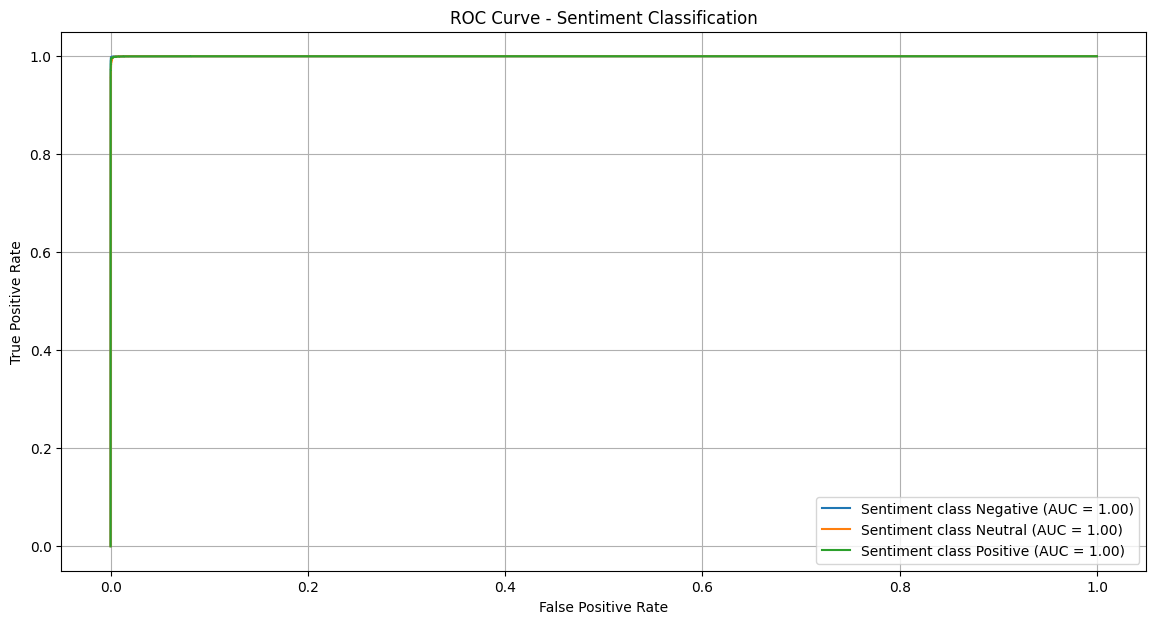

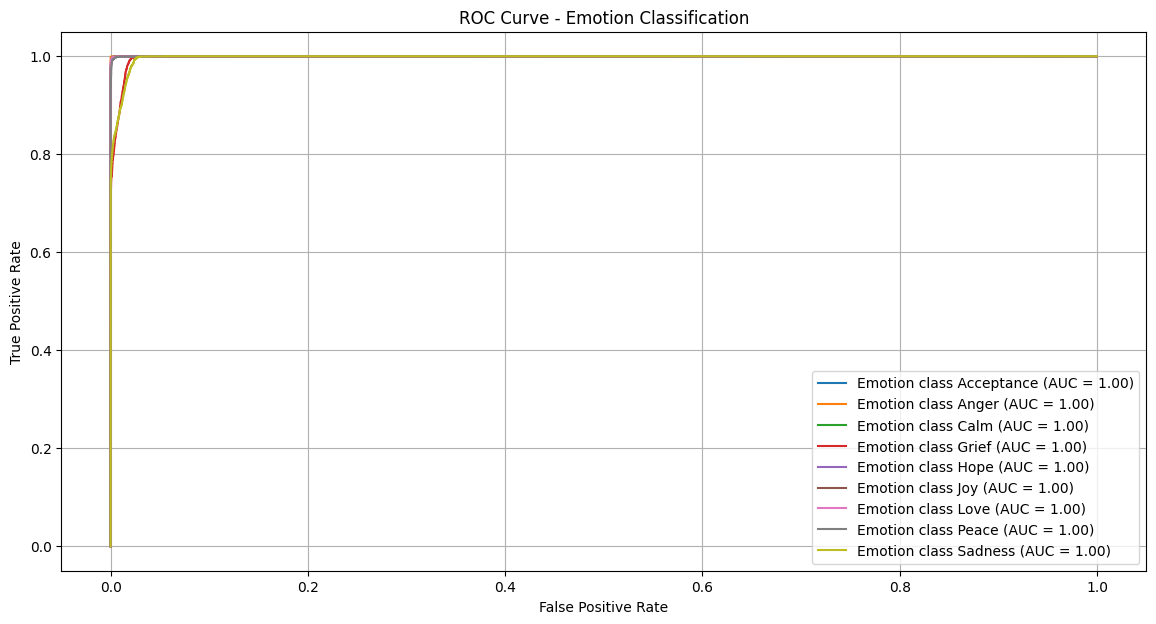

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the sentiment and emotion labels for AUC calculation
y_sentiment_test_binarized = label_binarize(y_sentiment_test, classes=range(len(sentiment_encoder.classes_)))
y_emotion_test_binarized = label_binarize(y_emotion_test, classes=range(len(emotion_encoder.classes_)))

# Get the predicted probabilities for each class
y_sentiment_pred_prob, y_emotion_pred_prob = model.predict(X_test_pad)

# Plot ROC curve for each sentiment class
plt.figure(figsize=(14, 7))
for i in range(len(sentiment_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_sentiment_test_binarized[:, i], y_sentiment_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Sentiment class {sentiment_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Sentiment Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot ROC curve for each emotion class
plt.figure(figsize=(14, 7))
for i in range(len(emotion_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_emotion_test_binarized[:, i], y_emotion_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Emotion class {emotion_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Emotion Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


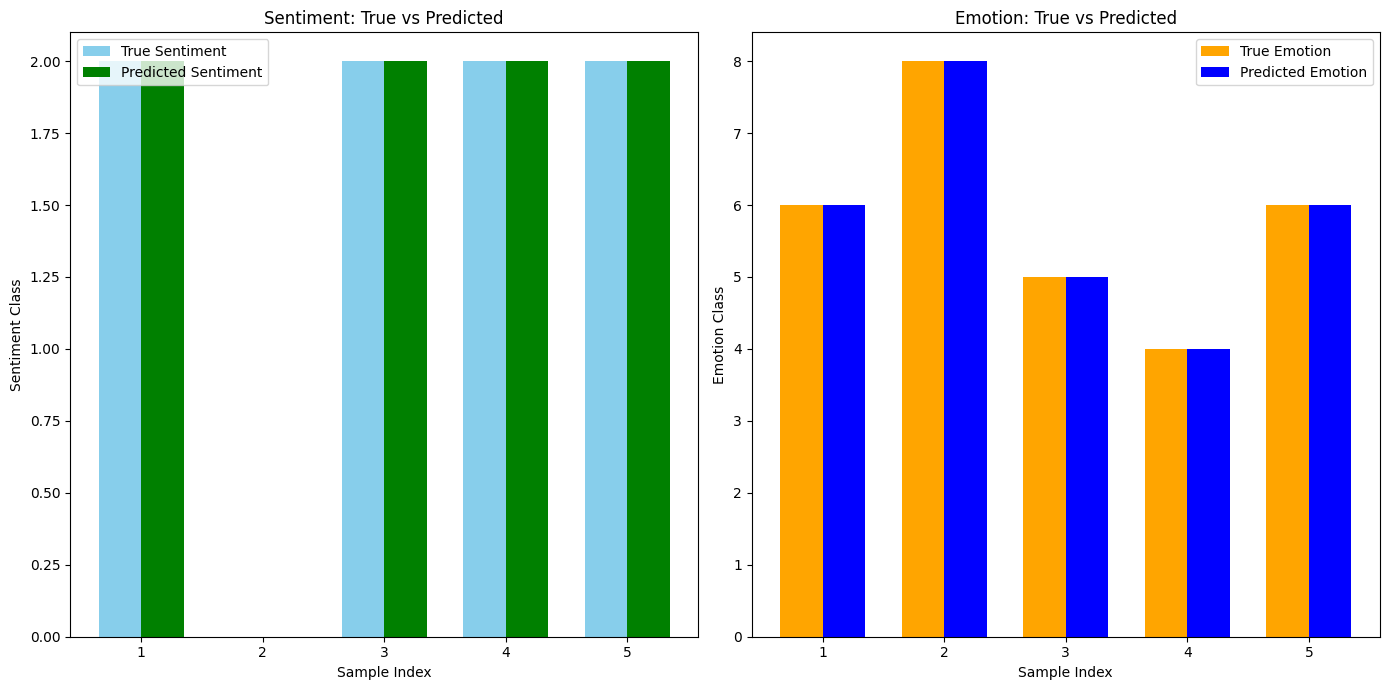

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X_test, y_sentiment_test, and y_emotion_test to NumPy arrays if they are pandas Series
X_test_np = np.array(X_test)
y_sentiment_test_np = np.array(y_sentiment_test)
y_emotion_test_np = np.array(y_emotion_test)

# Randomly select 5 sentences from the test set for testing
random_sample_indices = np.random.choice(len(X_test_pad), size=5, replace=False)

# Use the random indices to select sentences and their true labels
sample_sentences = X_test_np[random_sample_indices]  # These are the cleaned sentences
sample_true_sentiments = y_sentiment_test_np[random_sample_indices]
sample_true_emotions = y_emotion_test_np[random_sample_indices]

# Predict sentiment and emotion for the random samples
sample_sentiment_pred, sample_emotion_pred = model.predict(X_test_pad[random_sample_indices])
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Set up the figure
plt.figure(figsize=(14, 7))

# Sentiment Comparison Bar Plot
plt.subplot(1, 2, 1)
x = np.arange(len(sample_sentences))  # Label locations
bar_width = 0.35  # Width of the bars

# Plot bars for true sentiment
plt.bar(x - bar_width / 2, sample_true_sentiments, width=bar_width, color='skyblue', label='True Sentiment')

# Plot bars for predicted sentiment
plt.bar(x + bar_width / 2, sample_sentiment_pred_labels, width=bar_width, color='green', label='Predicted Sentiment')

# Label the plot
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Class')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Emotion Comparison Bar Plot
plt.subplot(1, 2, 2)

# Plot bars for true emotion
plt.bar(x - bar_width / 2, sample_true_emotions, width=bar_width, color='orange', label='True Emotion')

# Plot bars for predicted emotion
plt.bar(x + bar_width / 2, sample_emotion_pred_labels, width=bar_width, color='blue', label='Predicted Emotion')

# Label the plot
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Emotion Class')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


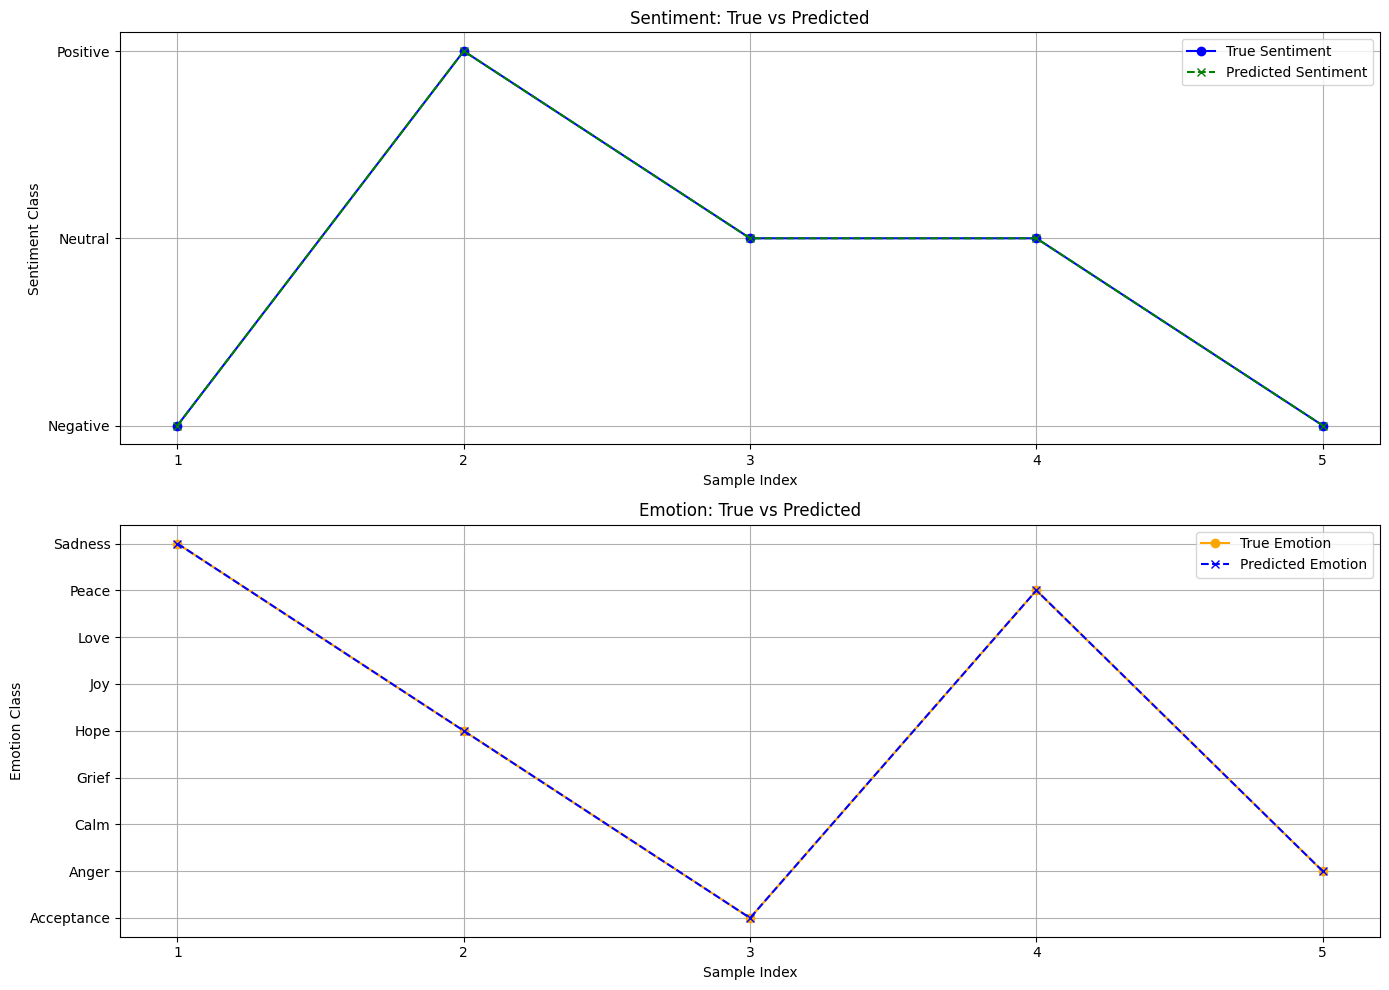

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X_test, y_sentiment_test, and y_emotion_test to NumPy arrays if they are pandas Series
X_test_np = np.array(X_test)
y_sentiment_test_np = np.array(y_sentiment_test)
y_emotion_test_np = np.array(y_emotion_test)

# Randomly select 5 sentences from the test set for testing
random_sample_indices = np.random.choice(len(X_test_pad), size=5, replace=False)

# Use the random indices to select sentences and their true labels
sample_sentences = X_test_np[random_sample_indices]  # These are the cleaned sentences
sample_true_sentiments = y_sentiment_test_np[random_sample_indices]
sample_true_emotions = y_emotion_test_np[random_sample_indices]

# Predict sentiment and emotion for the random samples
sample_sentiment_pred, sample_emotion_pred = model.predict(X_test_pad[random_sample_indices])
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Get all possible sentiment and emotion labels
sentiment_classes = sentiment_encoder.classes_  # All possible sentiment labels
emotion_classes = emotion_encoder.classes_  # All possible emotion labels

# Set up the line graph figure
plt.figure(figsize=(14, 10))

# Sentiment Plot: True vs Predicted
plt.subplot(2, 1, 1)
plt.plot(range(1, len(sample_sentences) + 1), sample_true_sentiments, marker='o', linestyle='-', color='blue', label='True Sentiment')
plt.plot(range(1, len(sample_sentences) + 1), sample_sentiment_pred_labels, marker='x', linestyle='--', color='green', label='Predicted Sentiment')
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Class')
plt.xticks(range(1, len(sample_sentences) + 1))  # x-axis represents the 5 randomly selected sentences
plt.yticks(ticks=range(len(sentiment_classes)), labels=sentiment_classes)  # Show all sentiment classes on y-axis
plt.legend()
plt.grid(True)

# Emotion Plot: True vs Predicted
plt.subplot(2, 1, 2)
plt.plot(range(1, len(sample_sentences) + 1), sample_true_emotions, marker='o', linestyle='-', color='orange', label='True Emotion')
plt.plot(range(1, len(sample_sentences) + 1), sample_emotion_pred_labels, marker='x', linestyle='--', color='blue', label='Predicted Emotion')
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Emotion Class')
plt.xticks(range(1, len(sample_sentences) + 1))  # x-axis represents the 5 randomly selected sentences
plt.yticks(ticks=range(len(emotion_classes)), labels=emotion_classes)  # Show all emotion classes on y-axis
plt.legend()
plt.grid(True)

# Adjust the layout and display the graph
plt.tight_layout()
plt.show()


In [ ]:
# Define custom Gujarati sentences for testing
custom_sentences = ["तेरी बातें दिल को सुकून देती हैं, जैसे सावन की पहली बारिश",
"दिल के कोने में कुछ टूटता हुआ सा महसूस होता है, जैसे पत्ते गिरते हैं शाखों से",
"अगर आप अपने सपनों को सच करना चाहते हैं, तो आपको लगातार प्रयास करना होगा",
"जब सह-अस्तित्व सहायता करता है, तब जीवन को अपनाना सरल हो जाता है",
"जब भोर की किरणें दिल को छूती हैं तो हर दिन एक नया उत्साह लेकर आता है"
]

# English translations of the custom sentences
english_translations = ["Your words bring peace to my heart, like the first rain of the monsoon",
"In the depths of my heart, there is a silence, like an instrument without melody",
"If you want to make your dreams come true, you have to keep making continuous efforts",
"When coexistence offers help, accepting life becomes easier",
"When the rays of dawn touch the heart, each day brings a new excitement"
]

# Preprocess and tokenize the custom sentences
custom_sequences = tokenizer.texts_to_sequences(custom_sentences)
custom_padded_sequences = pad_sequences(custom_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion using the trained model
custom_sentiment_pred, custom_emotion_pred = model.predict(custom_padded_sequences)

# Convert predictions to class labels
custom_sentiment_pred_labels = np.argmax(custom_sentiment_pred, axis=1)
custom_emotion_pred_labels = np.argmax(custom_emotion_pred, axis=1)

# Get the label names from encoders
predicted_sentiment_labels = sentiment_encoder.inverse_transform(custom_sentiment_pred_labels)
predicted_emotion_labels = emotion_encoder.inverse_transform(custom_emotion_pred_labels)

# Display the results for each sentence
for i, sentence in enumerate(custom_sentences):
    print(f"Sentence (Gujarati): {sentence}")
    print(f"English Translation: {english_translations[i]}")
    print(f"Predicted Sentiment: {predicted_sentiment_labels[i]}")
    print(f"Predicted Emotion: {predicted_emotion_labels[i]}")
    print("----------------------------------------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence (Gujarati): तेरी बातें दिल को सुकून देती हैं, जैसे सावन की पहली बारिश
English Translation: Your words bring peace to my heart, like the first rain of the monsoon
Predicted Sentiment: Positive
Predicted Emotion: Love
----------------------------------------------------
Sentence (Gujarati): दिल के कोने में कुछ टूटता हुआ सा महसूस होता है, जैसे पत्ते गिरते हैं शाखों से
English Translation: In the depths of my heart, there is a silence, like an instrument without melody
Predicted Sentiment: Negative
Predicted Emotion: Sadness
----------------------------------------------------
Sentence (Gujarati): अगर आप अपने सपनों को सच करना चाहते हैं, तो आपको लगातार प्रयास करना होगा
English Translation: If you want to make your dreams come true, you have to keep making continuous efforts
Predicted Sentiment: Positive
Predicted Emotion: Hope
----------------------------------------------------
Sentence (Gujarati): जब सह-अस्तित्व सहायता करता है, तब जीवन को अपन